# Homework 18: Neural Networks

**1.	What is a neural network? What are the general steps required to build a neural network?** 

A neural network is a type of machine learning algorithm that mimics the human brain in terms of processing. Neural networks require input layers, hidden layers, and output layers. There are intrictate relationships among these layers, where one node will be learning and feeding off others. These complex patterns and interactions among inputs/hidden layers/output are captured by different "activation functions" which transform our original inputs into eventual outputs.

First, we use forward propogation on our network (going from input to ouput) to calculate errors in our model. Then, we can use backward propogation (going backwards in our network) to see how any changes would impact our predicted and actual values. This also helps minimize the loss function in our model and improves accruacy. 

**2.	Generally, how do you check the performance of a neural network? Why?** 

You can measure the usefulness of your model by computing a performance metric (e.g. 'accuracy') on your validation set, through a series of epochs (iterations). We do this because it would be too computationally strenuous to run a k-fold number of tests on your data, for example. We can keep training our model and examining the epochs until we stop improving our performance metric. Once the metric stops improving, we have our final model.  

**Pre-processing abalone data set for future questions**

Load in modules and data file

In [2]:
# Load in basic libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the file
abalone = pd.read_csv('../homework17/abalone.csv')

# Original data length
print(str(len(abalone.index))+' rows')

# View file
abalone.sample(5)

4177 rows


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
2127,I,0.400,0.310,0.100,0.1270,0.1060,0.0710,0.0850,7
285,F,0.535,0.415,0.170,0.8790,0.2950,0.1965,0.2850,10
406,M,0.450,0.355,0.115,0.4790,0.2125,0.1045,0.1500,8
1831,I,0.365,0.270,0.075,0.2215,0.0950,0.0445,0.0700,6
1397,M,0.645,0.500,0.195,1.4010,0.6165,0.3515,0.3725,10


Complete pre-processing steps

In [3]:
# Encode the sex variables into binary
sex_enc = pd.get_dummies(abalone['Sex'])

# Concatenate the data frames and confirm that the encoding seems correct
abalone_df = pd.concat([abalone, sex_enc], axis=1)
abalone_df.head() # everything looks good

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,F,I,M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [4]:
# Drop the original sex variable from data frame
abalone_df = abalone_df.drop('Sex', axis=1)

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Create age variable
# According to the data information, the age is equal to the number of rings + 1.5
abalone_df['Age'] = abalone_df['Rings'] + 1.5

In [6]:
# drop Rings
abalone_df = abalone_df.drop('Rings', axis=1)

In [7]:
# Create the correlation matrix
abalone_df.corr()

# Revise the above to eliminate the perfect correlations (vars with themselves)
# Also eliminate duplicate entries
# This will make our matrix easier to interpret

# First get the correlations from our data frame
abalone_corr = abs(abalone_df.corr())

# Convert to easier format (for visualization)
abalone_corr_tri = abalone_corr.mask(np.triu(np.ones(abalone_corr.shape)).astype(np.bool))

# Now, we no longer have the duplicates, nor the perfect correlations!

In [8]:
# Drop the first row and the last column, since those are only NAs
abalone_corr_tri = abalone_corr_tri.drop(index='Length', columns='Age')
abalone_corr_tri.head(10)

# Round everything to 2 decimal places so that heatmap is easier to read
abalone_corr_tri2 = abalone_corr_tri.round(2)

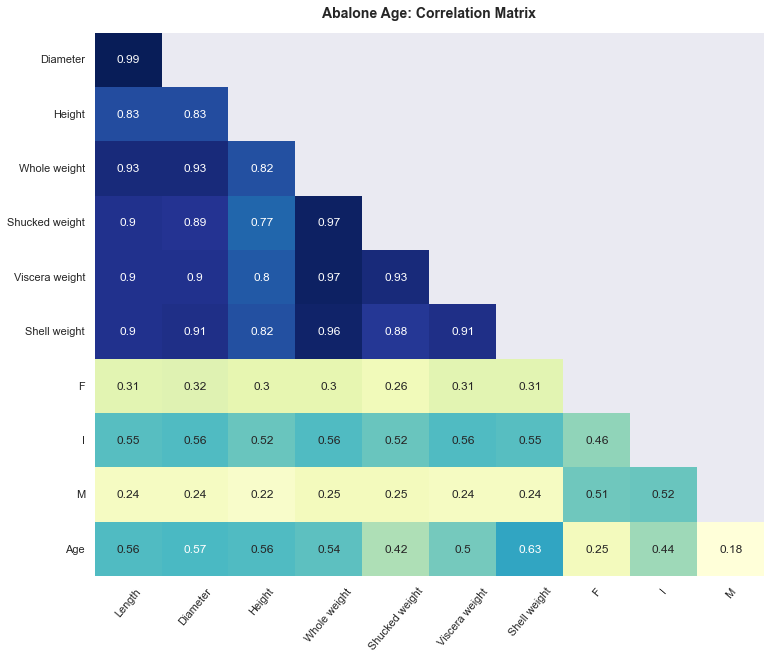

In [9]:
sns.set(rc={'figure.figsize':(12,10)})

# Visually display the matrix from above
# use the yellow-green-blue color map so that high correlations are more easily identifiable
h = sns.heatmap(abalone_corr_tri2, annot=True, cmap="YlGnBu", cbar=False)

# Add plot title 
h.set_title('Abalone Age: Correlation Matrix', size=14, weight='bold', pad=15)

# rotate tick marks so they are easier to read
plt.xticks(rotation=50)

# Display plot
plt.show()

Multicollinearity is not as much of an issue for neural networks. However, because "whole weight" is a near perfect correlation with shucked weight, viscera weight, and shell weight, it was more necessary to remove "whole weight," as it is a redundant feature. I also dropped "Height" and "Length" since they are too redundant with "Diameter." Finally, male and female were removed since they have quite low correlations with age. 

In [10]:
# features to keep
abalone_final = abalone_df.drop(['Height', 'Length', 'Whole weight', 'M', 'F'], axis=1)
# View refined data set
abalone_final.head()

,Diameter,Shucked weight,Viscera weight,Shell weight,I,Age
0,0.365,0.2245,0.1010,0.150,0,16.5
1,0.265,0.0995,0.0485,0.070,0,8.5
2,0.420,0.2565,0.1415,0.210,0,10.5
3,0.365,0.2155,0.1140,0.155,0,11.5
4,0.255,0.0895,0.0395,0.055,1,8.5


In [27]:
abalone_final['Age'].nunique()

28

Standardize data and split into training vs. testing tests

In [62]:
# Import necessary modules
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Predictors
X = abalone_final.drop('Age', axis=1)
# Outcome
y = abalone_final['Age']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=33)

#Standardize
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

**3.	Create a neural network using keras to predict the outcome of either of these datasets:**
- Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 
- Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone 

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, History

# Find number of predictors
p = X_train.shape[1]

# Create a sequential model instance
model = Sequential()

# Add the first layer with the input neurons and 3 hidden neurons
model.add(Dense(100, activation='relu', input_shape=(p,)))
# Add second layer with 3 more hidden neurons
model.add(Dense(100, activation='relu'))
# Add the final output layer
model.add(Dense(1))

In [55]:
# stop training if epoch does not have improved score after 3 times in a row
early_stopping_monitor = EarlyStopping(monitor='loss', patience=3)
# to retrieve the history
history = History()
# Compile our regression model, using the adamax optimizer and mean absolute error for loss function
# I chose mae because this data set has a severe number of outliers; mae is more robust to outliers than mse
model.compile(optimizer='adamax', loss='mae')
# Fit the model to our data
model.fit(X_train, y_train, callbacks=[early_stopping_monitor, history], epochs=500)

Epoch 1/500
92/92 [==============================] - 1s 3ms/step - loss: 8.1484
Epoch 2/500
92/92 [==============================] - 0s 3ms/step - loss: 3.4015
Epoch 3/500
92/92 [==============================] - 0s 2ms/step - loss: 2.0397
Epoch 4/500
92/92 [==============================] - 0s 2ms/step - loss: 1.6778
Epoch 5/500
92/92 [==============================] - 0s 2ms/step - loss: 1.5982
Epoch 6/500
92/92 [==============================] - 0s 2ms/step - loss: 1.5611
Epoch 7/500
92/92 [==============================] - 0s 2ms/step - loss: 1.5444A: 0s - loss: 1.563
Epoch 8/500
92/92 [==============================] - 0s 2ms/step - loss: 1.5266
Epoch 9/500
92/92 [==============================] - 0s 2ms/step - loss: 1.5139
Epoch 10/500
92/92 [==============================] - 0s 2ms/step - loss: 1.5067A: 0s - loss: 1.4
Epoch 11/500
92/92 [==============================] - 0s 3ms/step - loss: 1.4918
Epoch 12/500
92/92 [==============================] - 0s 2ms/step - loss: 1.4892
E

In [52]:
# Use model to predict new data (our testing data)
y_pred = model.predict(X_test)
# View age predictions
print(y_pred)
# Evaluate results
model.evaluate(X_test, y_test)

[[12.253674]
 [12.756935]
 [11.462702]
 ...
 [16.628637]
 [ 9.509329]
 [11.781964]]
40/40 [==============================] - 0s 2ms/step - loss: 1.5718


1.5717980861663818

On average, the predictions for this model are about 1.57 units away from the true age value

In [60]:
# Final loss
print('Keras NN MAE Loss: 1.57')

Keras NN MAE Loss: 1.57


**4.	Write another algorithm to predict the same result as the previous question using either KNN or logistic regression.**

https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/ - resource I found KNN

In [61]:
# Import module to conduct the K nearest neighbors algorithm
from sklearn.neighbors import KNeighborsRegressor

### General rule of thumb of where to start: square root of number of rows
np.sqrt(len(abalone_df.index))

64.6297145282261

Find the best k value. It should be somewhere close to 65

In [63]:
# Write function to test best score
    # Test several values for the n_neighbors

# Create lists to append to
mae_list = []
K_list = []

# Define function
def best_score():   
    # Create a range for K to be in
    for k in range(50,100):
        # Check that K is odd (that way we don't have ties)
        if k%2 !=0:
            # Set the K-neighbors regressor
            knn = KNeighborsRegressor(n_neighbors=k)
            # Fit to the training data
            knn.fit(X_train, y_train)
            # Predict the testing data
            y_pred_knn = knn.predict(X_test)
            # Find mae
            mae_knn = MAE(y_test, y_pred_knn)
            # append the score to the mse list
            mae_list.append(mae_knn)
            # append the K value to the K_list
            K_list.append(k)
    else:
        pass
    
    # Create data frame that contains the values from our two lists
    knn_df = pd.DataFrame({'MAE':mae_list,
                          'K': K_list})
    # Sort df by mimimum mae (lowest to highest), and then by K (lowest to highest)
    # Change the index to match the sorted data
    knn_sort = knn_df.sort_values(['MAE','K'], ascending=[True,True], ignore_index=True)
    
    # Return the top row of the df
    print(knn_sort.loc[0])

    # Build the scatter plot
    g = sns.scatterplot(data=knn_sort,
                    x='K',
                    y='MAE',
                    color='m',
                    hue='MAE',
                    alpha=0.9,
                    edgecolor='grey',
                    linewidth=0.8,
                    legend=False)

    # Add plot title and adjust the y-axis label to include units
    g.set_title('K Values with MAE', size=14, weight='bold', pad=15)  

    # Display plot
    plt.show()

According to the results, the best value to use for K is 57, which is consistent with the plot below

MAE     1.603976
K      57.000000
Name: 0, dtype: float64


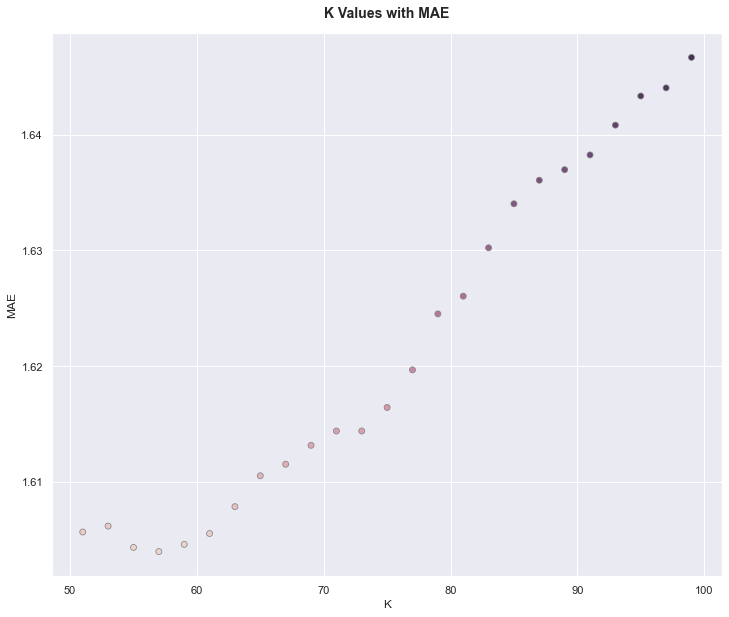

In [64]:
best_score()

In [65]:
# Create the knn model and choose our k-value
knn=KNeighborsRegressor(n_neighbors=57)
# Fit the model to our training data
knn.fit(X_train, y_train)
# Predict on our testing set
y_pred_knn = knn.predict(X_test)
# pring predictions
print(y_pred_knn)

[12.53508772 12.90350877 11.21929825 ... 15.55263158  9.51754386
 12.3245614 ]


In [66]:
# Calculate the mean absolute error on testing data
mae_knn = MAE(y_test, y_pred_knn)
# View results
print(f' KNN MAE: {mae_knn}')

 KNN MAE: 1.6039760485743866


Tune model further to see if we can get a better score

In [67]:
# Import to search for best parameters
from sklearn.model_selection import GridSearchCV

# Setup the parameters that we will test on our KNN model
param_dict = {'n_neighbors': [57],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(30,50),
    
}
            
# Instantiate the model
knnr = KNeighborsRegressor() 

In [68]:
# Run the decision tree model through the search, using the specified parameters and 10 crossfold validation
grid = GridSearchCV(knnr, 
                    param_grid = param_dict, 
                    cv=10,
                    scoring = 'neg_mean_absolute_error',
                    refit='neg_mean_absolute_error')

# Fit the search to our training data
grid.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned KNN Parameters: {}".format(grid.best_params_))
print("Best MAE from KNN model is {}".format(grid.best_score_))

Tuned KNN Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'n_neighbors': 57, 'weights': 'distance'}
Best MAE from KNN model is -1.4922179208481912


In [69]:
# Use the results from above to create a model with the best parameters
best_knn=KNeighborsRegressor(n_neighbors=57, algorithm='brute', leaf_size=30, weights='distance')
# Fit the model to our training data
best_knn.fit(X_train, y_train)
# Predict on our testing set
y_pred_best_knn = best_knn.predict(X_test)

# Calculate the mean absolute error to get MAE
mae_best_knn = MAE(y_test, y_pred_best_knn)
# View results
print(f' Tuned KNN MAE: {mae_best_knn}')

 Tuned KNN MAE: 1.592023629682022


On average, the predictions for this model are about 1.59 units away from the true age value

**5.	Create a neural network using pytorch to predict the same result as question 3.** 

Transform the x and y variables to work as tensors. Then, split again into training vs. testing sets

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F #where the activation functions are

# Predictors
X2 = X.values # transform x from earlier into float for tensor
# Outcome
y2 = y.values # transform y from earlier into float for tensor

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3, random_state=33)

#Standardize
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

#create tensors
X_train_t = torch.FloatTensor(X_train) 
X_test_t = torch.FloatTensor(X_test)

y_train_t = torch.FloatTensor(y_train)
y_test_t = torch.FloatTensor(y_test)

# View training data
print(X_train_t)

tensor([[-1.3771, -1.2435, -1.1589, -1.1785, -0.6955],
        [ 0.9444,  0.4956,  1.0707,  0.8997, -0.6955],
        [ 0.2379, -0.2376, -0.2487, -0.0828,  1.4378],
        ...,
        [ 1.2472,  2.1797,  2.0131,  1.2321, -0.6955],
        [ 0.3893,  0.1313,  0.2754,  0.1364,  1.4378],
        [-1.5285, -1.2984, -1.1773, -1.2880, -0.6955]])


Create the neural network, using pytorch method

In [71]:
#artificial neural network
class ANN_Model(nn.Module):
    # Use same number of layers as earlier model to be consistent
    def __init__(self, input_features=5,hidden1=100,hidden2=100,out_features=1):
        super().__init__() #super is a computed indirect reference. So, it isolates changes
        # and makes sure that children in the layers of multiple inheritence are calling
        #the right parents
        self.layer_1_connection = nn.Linear(input_features, hidden1)
        self.layer_2_connection = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, out_features)
        
    def forward(self, x):
        #apply activation functions
        x = F.relu(self.layer_1_connection(x))
        x = F.relu(self.layer_2_connection(x))
        x = self.out(x)
        return x

In [72]:
# Create random seed
torch.manual_seed(33)

# Create instance of model
ann = ANN_Model()

In [76]:
# Loss function
loss_function = nn.L1Loss() # for mean absolute error

# Optimizer - use adamax to be consistent with earlier model
# learning rate of 0.01
optimizer = torch.optim.Adamax(ann.parameters(), lr=1e-4)

In [77]:
#run model through multiple epochs/iterations
final_loss = []
n_epochs = 500 # same as earlier model for consistency
for epoch in range(n_epochs):
    y_pred_t = ann.forward(X_train_t)
    loss = loss_function(y_pred_t, y_train_t)
    final_loss.append(loss)
    
    if epoch % 10 == 1:
        print(f'Epoch number: {epoch} with loss: {loss}')
        
    optimizer.zero_grad() #zero the gradient before running backwards propagation
    loss.backward() 
    optimizer.step() #perform one optimization step each epoch

Epoch number: 1 with loss: 2.3052756786346436
Epoch number: 11 with loss: 2.3050551414489746
Epoch number: 21 with loss: 2.3048553466796875
Epoch number: 31 with loss: 2.304678201675415
Epoch number: 41 with loss: 2.3045220375061035
Epoch number: 51 with loss: 2.3043808937072754
Epoch number: 61 with loss: 2.3042490482330322
Epoch number: 71 with loss: 2.3041250705718994
Epoch number: 81 with loss: 2.3040049076080322
Epoch number: 91 with loss: 2.3038904666900635
Epoch number: 101 with loss: 2.3037803173065186
Epoch number: 111 with loss: 2.3036773204803467
Epoch number: 121 with loss: 2.303579330444336
Epoch number: 131 with loss: 2.303488254547119
Epoch number: 141 with loss: 2.303401231765747
Epoch number: 151 with loss: 2.303318738937378
Epoch number: 161 with loss: 2.303241729736328
Epoch number: 171 with loss: 2.303168535232544
Epoch number: 181 with loss: 2.30309796333313
Epoch number: 191 with loss: 2.303030490875244
Epoch number: 201 with loss: 2.302967071533203
Epoch number: 

The best MAE for this model is 2.30, so on average the predicted age is about 2.3 units away from the true age.

**6.	Compare the performance of the neural networks to the other model you created. Which performed better? Why do you think that is?**

To summarize, I achieved the following RMSE scores for my models:
1) Keras NN MAE: 1.57

2) Tuned KNN MAE: 1.59

3) Pytorch NN MAE = 2.30

The results above show that the Keras neural network performed the best on this data set. For both neural networks, I selected 5 input features, 2 hidden layers with 100 nodes and then my output feature. I used 'MAE' for the loss function and the adamax optimizer. I also used the relu activation for both. I used the same values for both neural network models to have a more proper comparison. I experimented with a range of nodes and layers, and having 2 layers at 100 seemed to produce the best results.

I am not too sure why Keras performed so much better than pytorch. It does make sense that keras would have been better than KNN, since keras has much more information going on under the hood and a lot more information to learn from. However, the KNN model still performed very well and was only slightly worse than the keras model. This might be because I further tuned the KNN model to help improve the score.  

# Data Camp

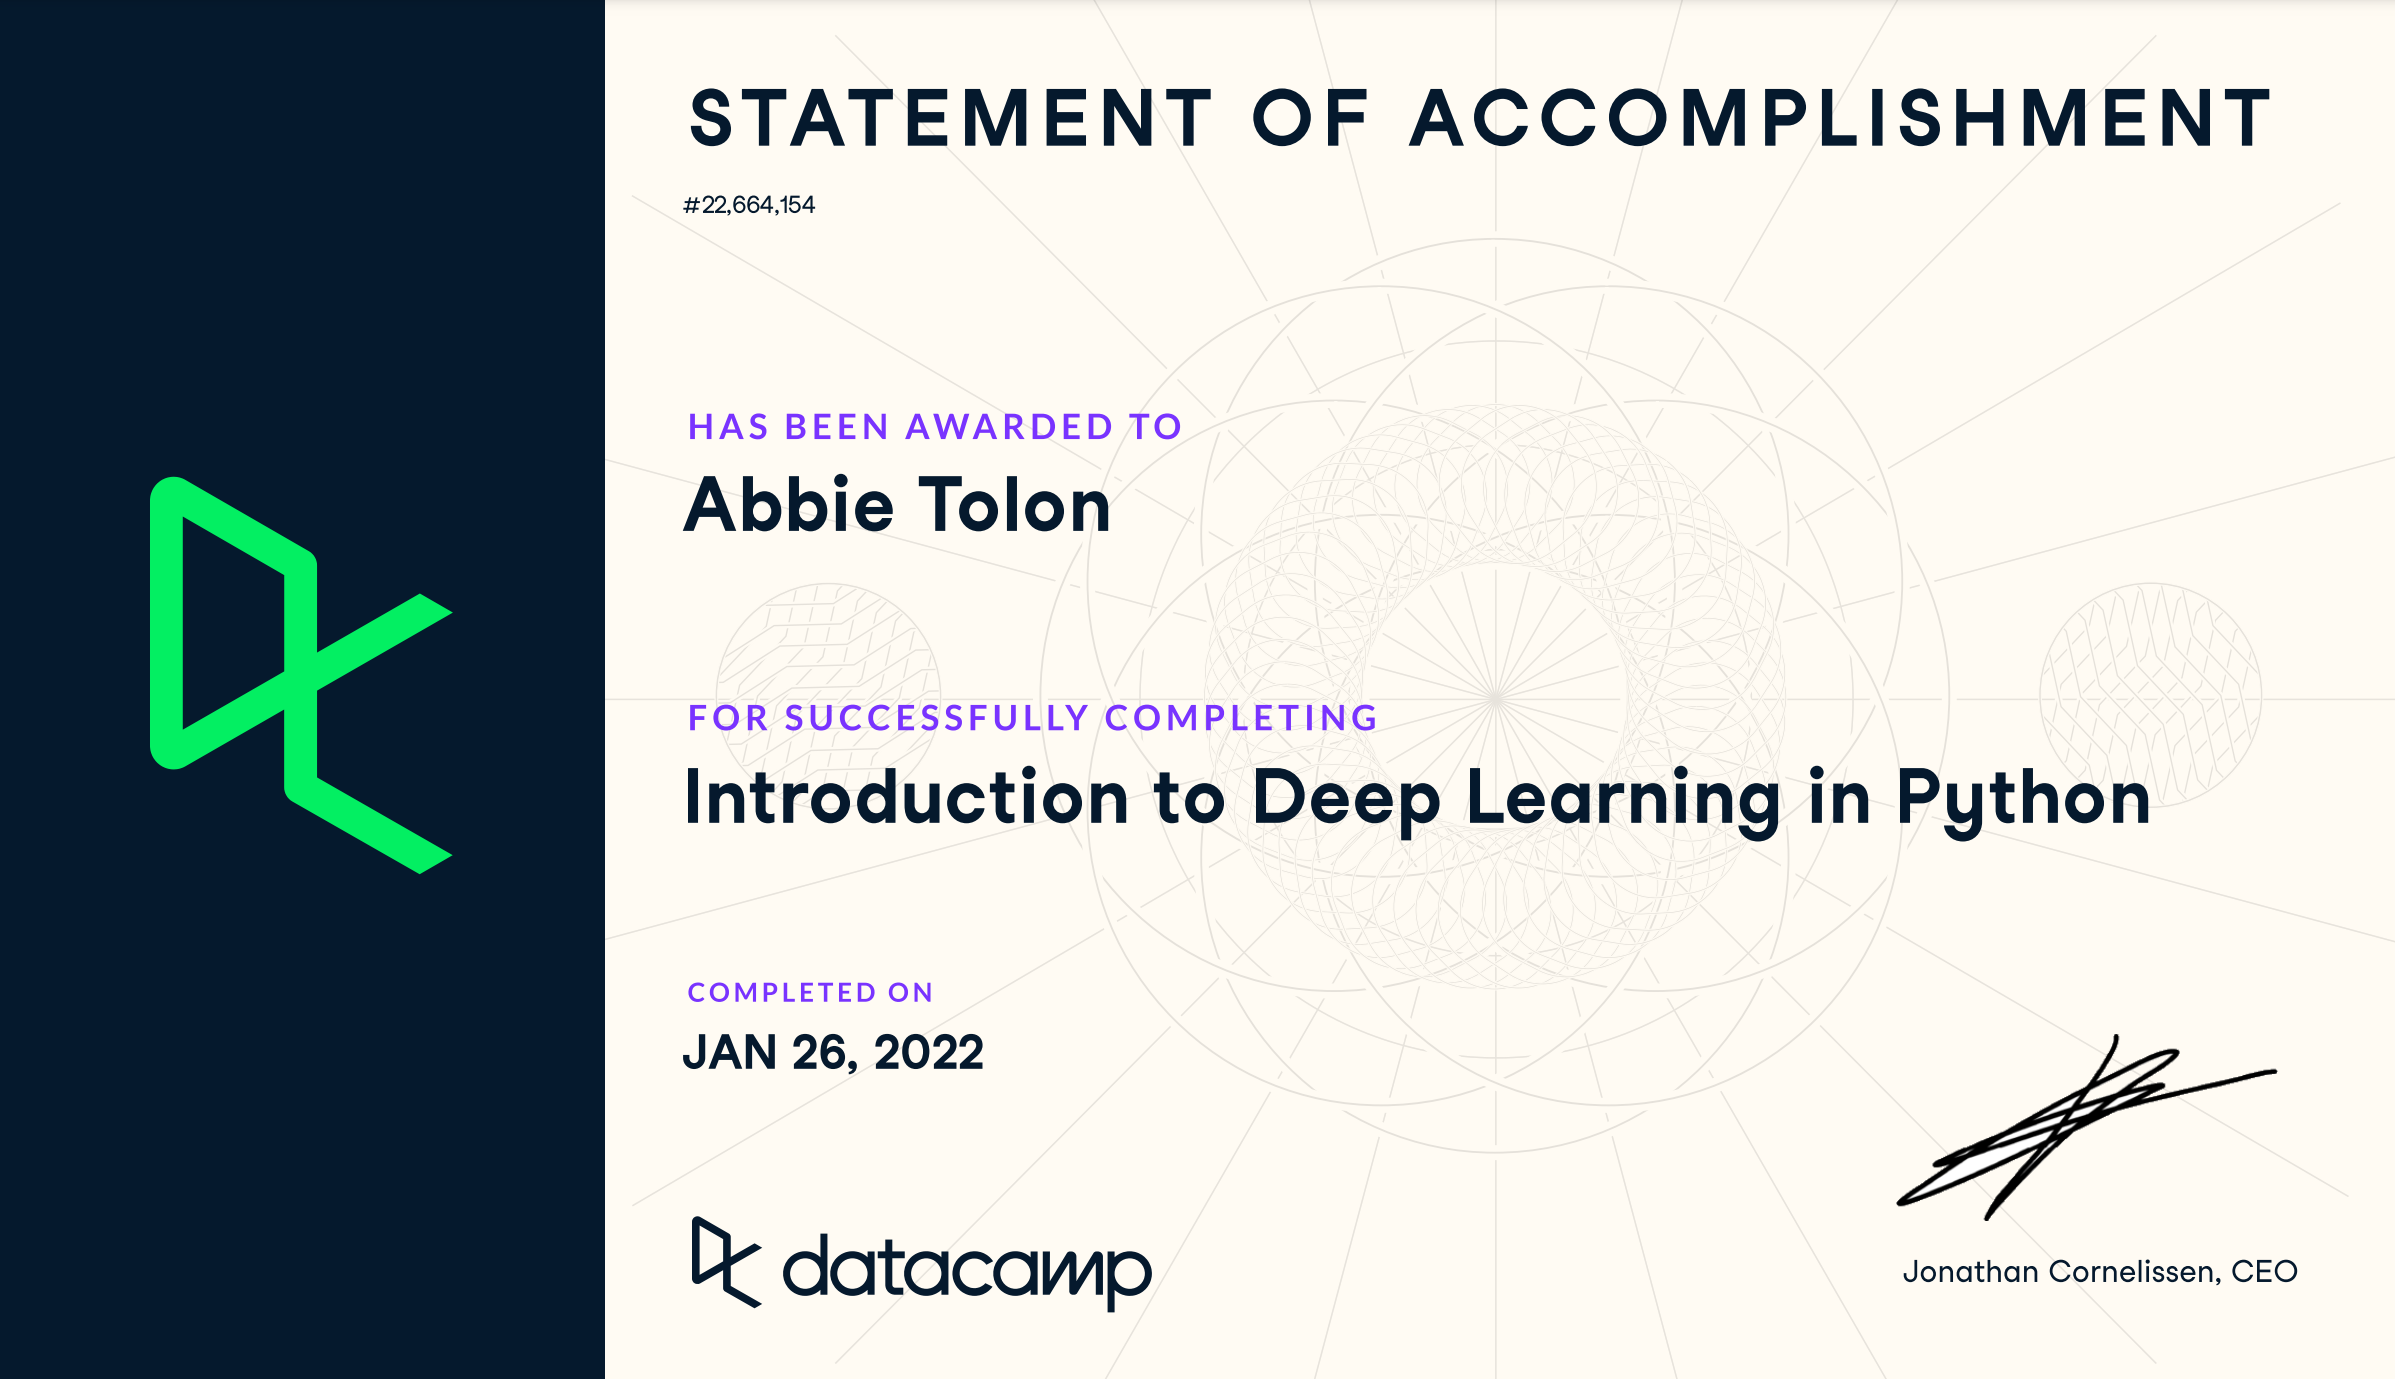